## 5.11 残差网络（ResNet）

### 5.11.1 残差块

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from livelossplot.tf_keras import PlotLossesCallback

In [2]:
class Residual(keras.layers.Layer):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, *args, **kwargs):
        super(Residual, self).__init__(*args, **kwargs)
        self.conv1 = keras.layers.Conv2D(num_channels, kernel_size=3, padding='same', strides=strides)
        self.conv2 = keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')
        
        if use_1x1conv:
           self.conv3 = keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
           self.conv3 = None
            
        self.bn1 = keras.layers.BatchNormalization()
        self.bn2 = keras.layers.BatchNormalization()
        
    def call(self, inputs, training=None, mask=None):
        Y = keras.layers.ReLU()(self.bn1(self.conv1(inputs)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
           inputs = self.conv3(inputs)
        return keras.layers.ReLU()(Y + inputs)
    

In [3]:
inp = keras.Input((4, 3, 3))
blk = Residual(3)(inp)
model = keras.Model(inp, blk)
model.output_shape

W1020 13:27:52.559117 140314552117056 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(None, 4, 3, 3)

### 5.11.2 ResNet模型

In [4]:
model = keras.Sequential()
model.add(keras.layers.Lambda(lambda img: tf.image.resize(img, (224, 224)), input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(224, 224, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.ReLU())
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))

In [5]:
def resnet_block(model, num_channels, num_residuals, first_block=False):
    for i in range(num_residuals):
        if i == 0 and not first_block:
            model.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            model.add(Residual(num_channels))
    return model

In [6]:
resnet_block(model, 64, 2, first_block=True),
resnet_block(model, 128, 2),
resnet_block(model, 256, 2),
resnet_block(model, 512, 2)

In [7]:
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10))
model.add(keras.layers.Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      3200      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_1 (Residual)        (None, 56, 56, 64)        74368     
_________________________________________________________________
residual_2 (Residual)        (None, 56, 56, 64)        7

### 5.11.3 获取数据和训练模型

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.

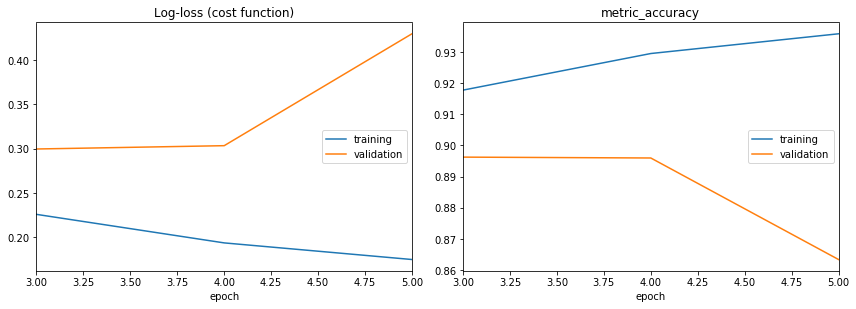

Log-loss (cost function):
training   (min:    0.175, max:    0.501, cur:    0.175)
validation (min:    0.300, max:    4.433, cur:    0.430)

metric_accuracy:
training   (min:    0.821, max:    0.936, cur:    0.936)
validation (min:    0.235, max:    0.896, cur:    0.863)
42000/42000 [==============================] - 56s 1ms/sample - loss: 0.1748 - metric_accuracy: 0.9359 - val_loss: 0.4295 - val_metric_accuracy: 0.8634


In [9]:
def metric_accuracy(y_true, y_pred):
    ytrue = K.flatten(y_true)
    ypred = K.cast(K.argmax(y_pred, axis=-1), K.floatx())
    acc = K.equal(ytrue, ypred)
    return K.mean(acc)

model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[metric_accuracy])

model.fit(
    x_train.reshape((x_train.shape[0], 28, 28, 1)), 
    y_train, epochs=5, batch_size=128,
    #validation_data=(x_test.reshape(x_test.shape[0], 28, 28, 1), y_test),
    validation_split=0.3,
    callbacks=[PlotLossesCallback()])